In [1]:
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.signal as signal
import scipy.stats as stats
import uncertainty_toolbox as uct

from typing import Any, Dict, List, Union
from tqdm import tqdm

from sklearn.metrics import auc, precision_recall_curve, roc_auc_score
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import train_test_split

from src.probabilistic_flow_boosting.extras.datasets.uci_dataset import UCIDataSet
from src.probabilistic_flow_boosting.tfboost.tree import EmbeddableCatBoostPriorNormal
from src.probabilistic_flow_boosting.tfboost.tfboost import TreeFlowBoost
from src.probabilistic_flow_boosting.tfboost.flow import ContinuousNormalizingFlow
from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll
from src.probabilistic_flow_boosting.pipelines.modeling.utils import setup_random_seed


pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
RANDOM_SEED = 42
TRAIN = False
MODEL_FILEPATH = 'treeflow_wine.model'

setup_random_seed(RANDOM_SEED)

In [3]:
def find_best_gmm_decomposition(
    data: np.ndarray, 
    max_components: int,
    gmm_args: Dict[Any, Any]
):
    models = []

    for i in range(1, max_components + 1):
        models.append(GaussianMixture(i, **gmm_args).fit(data))

    # compute the AIC and the BIC
    AIC = [m.aic(data) for m in models]
    BIC = [m.bic(data) for m in models]

    M_best = models[np.argmin(AIC)]
    return M_best, AIC, BIC


def find_bgmm_decomposition(
    data: np.ndarray, 
    bgmm_args: Dict[Any, Any]
):
    return BayesianGaussianMixture(**bgmm_args).fit(data)


def select_prediction_with_std(model: Union[GaussianMixture, BayesianGaussianMixture], method = None):
    if method == 'weights':
        best = np.argmax(model.weights_)
    elif method == 'covariance':
        best = np.argmin(model.covariances_)
    else:
        raise ValueError(f'Method {method} is not supported')
    return model.means_[best], model.covariances_[best]


def calculate_treeflow_gmm_predictions(samples: np.ndarray, max_components: int = 10, gmm_args: Dict[Any, Any] = None, method = 'weights'):
    if gmm_args is None:
        gmm_args = {}
    
    y_mean = []
    y_std = []

    for sample in tqdm(samples):
        M_best, AIC, BIC = find_best_gmm_decomposition(
            data = sample.reshape(-1, 1),
            max_components = max_components,
            gmm_args = gmm_args
        )
        mean, var = select_prediction_with_std(M_best, method = method)
        y_mean.append(mean)
        y_std.append(np.sqrt(var))

    y_mean = np.array(y_mean).reshape(-1)
    y_std = np.array(y_std).reshape(-1)
    return y_mean, y_std


def calculate_treeflow_bgmm_predictions(samples: np.ndarray, bgmm_args: Dict[Any, Any] = None, method = 'weights'):
    if bgmm_args is None:
        bgmm_args = {}
    
    y_mean = []
    y_std = []

    for sample in tqdm(samples):
        M_best = find_bgmm_decomposition(
            data = sample.reshape(-1, 1),
            bgmm_args = bgmm_args
        )
        mean, var = select_prediction_with_std(M_best, method = method)
        y_mean.append(mean)
        y_std.append(np.sqrt(var))

    y_mean = np.array(y_mean).reshape(-1)
    y_std = np.array(y_std).reshape(-1)
    return y_mean, y_std

In [4]:
x_train = UCIDataSet(
    filepath_data = "data/01_raw/UCI/wine-quality-red/data.txt",
    filepath_index_columns = "data/01_raw/UCI/wine-quality-red/index_features.txt",
    filepath_index_rows = "data/01_raw/UCI/wine-quality-red/index_train_1.txt"
).load()
y_train = UCIDataSet(
    filepath_data = "data/01_raw/UCI/wine-quality-red/data.txt",
    filepath_index_columns = "data/01_raw/UCI/wine-quality-red/index_target.txt",
    filepath_index_rows = "data/01_raw/UCI/wine-quality-red/index_train_1.txt"
).load()

x_test = UCIDataSet(
    filepath_data = "data/01_raw/UCI/wine-quality-red/data.txt",
    filepath_index_columns = "data/01_raw/UCI/wine-quality-red/index_features.txt",
    filepath_index_rows = "data/01_raw/UCI/wine-quality-red/index_test_1.txt"
).load()
y_test = UCIDataSet(
    filepath_data = "data/01_raw/UCI/wine-quality-red/data.txt",
    filepath_index_columns = "data/01_raw/UCI/wine-quality-red/index_target.txt",
    filepath_index_rows = "data/01_raw/UCI/wine-quality-red/index_test_1.txt"
).load()

In [5]:
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=RANDOM_SEED)

In [6]:
if TRAIN:
    tree = EmbeddableCatBoostPriorNormal(
        loss_function="RMSEWithUncertainty",
        depth=2,
        num_trees=300,
        random_state=RANDOM_SEED
    )
    flow = ContinuousNormalizingFlow(input_dim=1, hidden_dims=(80, 80, 40), 
                                     num_blocks=3, context_dim=40, conditional=True)

    treeflow = TreeFlowBoost(tree, flow, embedding_size=40)

    treeflow.fit(x_tr.values, y_tr.values, x_val.values, y_val.values, n_epochs=200, batch_size=2048, verbose=True)
    treeflow.save(MODEL_FILEPATH)
else:
    treeflow = TreeFlowBoost.load(MODEL_FILEPATH)

In [7]:
calculate_nll(treeflow, x_test, y_test, batch_size=2048)

0.152124

In [8]:
model_tree = catboost.CatBoostRegressor(loss_function='RMSEWithUncertainty', random_seed=RANDOM_SEED, verbose=False)
model_tree.fit(x_tr, y_tr, eval_set=(x_val, y_val))

In [9]:
# CatBoost
y_test_catboost = model_tree.predict(x_test)
y_test_catboost_mean = y_test_catboost[:, 0]
y_test_catboost_std = np.sqrt(y_test_catboost[:, 1])

# TreeFlow Samples
y_test_samples = treeflow.sample(x_test, num_samples=1000).squeeze()

# TreeFlow Gaussianized
y_test_treeflow_gaussianized_mean = np.mean(y_test_samples, axis = 1)
y_test_treeflow_gaussianized_std = np.std(y_test_samples, axis = 1)

# TreeFlow GMM
y_test_treeflow_gmm_mean, y_test_treeflow_gmm_std = calculate_treeflow_gmm_predictions(
    y_test_samples, 
    max_components = 2, 
    gmm_args = dict(random_state=RANDOM_SEED, n_init=5),
    method = 'weights'
)

# TreeFlow BGMM
y_test_treeflow_bgmm_mean, y_test_treeflow_bgmm_std = calculate_treeflow_bgmm_predictions(
    y_test_samples, 
    bgmm_args = dict(random_state=RANDOM_SEED, n_init=5, n_components=5, max_iter=1000),
    method = 'weights'
)

# TreeFlow Sample Logprob
lps = treeflow.log_prob(np.repeat(x_test.values, 1000, axis = 0), y_test_samples.reshape(-1, 1))
lps = lps.reshape(*y_test_samples.shape)
indices_treeflow_sample_logprob = lps.argmax(axis = 1)

y_test_treeflow_sample_logprob = np.take(y_test_samples, indices_treeflow_sample_logprob)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [01:52<00:00,  1.43it/s]


In [10]:
print(
    y_test_catboost_mean.shape,
    y_test_catboost_std.shape,
    y_test_treeflow_gaussianized_mean.shape,
    y_test_treeflow_gaussianized_std.shape,
    y_test_treeflow_gmm_mean.shape,
    y_test_treeflow_gmm_std.shape,
    y_test_treeflow_bgmm_mean.shape,
    y_test_treeflow_bgmm_std.shape,
    y_test_treeflow_sample_logprob.shape
)

(160,) (160,) (160,) (160,) (160,) (160,) (160,) (160,) (160,)


## Samples comparison

In [11]:
for i in range(10):
    print(i)
    plt.axvline(x=y_test.values[i, :], color='r', label='True value')

    ## TreeFlow
    sns.kdeplot(y_test_samples[i, :], color='blue', label='TreeFlow')

    ## TreeFlow Gaussianized
    x = np.linspace(
        stats.norm.ppf(0.001, loc=y_test_treeflow_gaussianized_mean[i], scale=y_test_treeflow_gaussianized_std[i]), 
        stats.norm.ppf(0.999, loc=y_test_treeflow_gaussianized_mean[i], scale=y_test_treeflow_gaussianized_std[i]), 
        100
    )
    plt.plot(x, stats.norm.pdf(x, loc=y_test_treeflow_gaussianized_mean[i], scale=y_test_treeflow_gaussianized_std[i]), color = 'green', label='TreeFlow "Gaussianised"')
    
    ## TreeFlow GMM
    x = np.linspace(
        stats.norm.ppf(0.001, loc=y_test_treeflow_gmm_mean[i], scale=y_test_treeflow_gmm_std[i]), 
        stats.norm.ppf(0.999, loc=y_test_treeflow_gmm_mean[i], scale=y_test_treeflow_gmm_std[i]), 
        100
    )
    plt.plot(x, stats.norm.pdf(x, loc=y_test_treeflow_gmm_mean[i], scale=y_test_treeflow_gmm_std[i]), color = 'violet', label='TreeFlow GMM')
    
    ## TreeFlow BGMM
    x = np.linspace(
        stats.norm.ppf(0.001, loc=y_test_treeflow_bgmm_mean[i], scale=y_test_treeflow_bgmm_std[i]), 
        stats.norm.ppf(0.999, loc=y_test_treeflow_bgmm_mean[i], scale=y_test_treeflow_bgmm_std[i]), 
        100
    )
    plt.plot(x, stats.norm.pdf(x, loc=y_test_treeflow_gmm_mean[i], scale=y_test_treeflow_gmm_std[i]), color = 'yellow', label='TreeFlow BGMM')
    
    ## TreeFlow CatBoost
    x = np.linspace(
        stats.norm.ppf(0.001, loc=y_test_catboost_mean[i], scale=y_test_catboost_std[i]), 
        stats.norm.ppf(0.999, loc=y_test_catboost_mean[i], scale=y_test_catboost_std[i]), 
        100
    )
    plt.plot(x, stats.norm.pdf(x, loc=y_test_catboost_mean[i], scale=y_test_catboost_std[i]), color = 'orange', label='CatBoost')
    
    plt.xlim([0, 10])
    plt.legend()
    # plt.show()
    plt.savefig(f'figures/samples_comparison_{i}.pdf')
    plt.close()

0
1
2
3
4
5
6
7
8
9


## Uncertainty Toolbox

In [12]:
def generate_uncertainty_results(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    model_name: str
):
    uct.viz.plot_adversarial_group_calibration(y_pred, y_std, y_true)
    plt.savefig(f'figures/adv_group_cal_{model_name}.pdf')
    plt.close()
    
    uct.viz.plot_calibration(y_pred, y_std, y_true)
    plt.savefig(f'figures/avg_cal_{model_name}.pdf')
    plt.close()
    
    uct.viz.plot_intervals_ordered(y_pred, y_std, y_true)
    plt.savefig(f'figures/ord_pred_int_{model_name}.pdf')
    plt.close()
    
    uct.viz.plot_residuals_vs_stds(y_pred, y_std, y_true)
    plt.savefig(f'figures/res_vs_std_{model_name}.pdf')
    plt.close()
    
    uct.viz.plot_sharpness(y_std)
    plt.savefig(f'figures/sharpness_{model_name}.pdf')
    plt.close()
    
    return uct.metrics.get_all_metrics(y_pred, y_std, y_true)

In [13]:
metrics_catboost = generate_uncertainty_results(
    y_pred = y_test_catboost_mean,
    y_std = y_test_catboost_std,
    y_true = y_test.values.squeeze(),
    model_name = 'catboost'
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.89it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.70it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.503
  RMSE          0.623
  MDAE          0.432
  MARPD         9.024
  R2            0.373
  Correlation   0.633
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.052
  Mean-absolute Calibration Error       0.041
  Miscalibration Area                   0.041
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.124
     Group Size: 0.56 -- Calibration Error: 0.067
     Group Size: 1.00 -- Calibration Error: 0.041
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.154
     Group Size: 0.56 -- Calibration Error: 0.085
     Group Size: 1.00 -- Calibration Error: 0.052
================

In [14]:
metrics_treeflow_gaussianized = generate_uncertainty_results(
    y_pred = y_test_treeflow_gaussianized_mean,
    y_std = y_test_treeflow_gaussianized_std,
    y_true = y_test.values.squeeze(),
    model_name = 'treeflow_gaussianized'
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.06it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.77it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.490
  RMSE          0.620
  MDAE          0.419
  MARPD         8.722
  R2            0.379
  Correlation   0.626
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.039
  Mean-absolute Calibration Error       0.030
  Miscalibration Area                   0.030
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.140
     Group Size: 0.56 -- Calibration Error: 0.060
     Group Size: 1.00 -- Calibration Error: 0.030
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.153
     Group Size: 0.56 -- Calibration Error: 0.069
     Group Size: 1.00 -- Calibration Error: 0.039
================

In [15]:
metrics_treeflow_gmm = generate_uncertainty_results(
    y_pred = y_test_treeflow_gmm_mean,
    y_std = y_test_treeflow_gmm_std,
    y_true = y_test.values.squeeze(),
    model_name = 'treeflow_gmm'
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.21it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.37it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.490
  RMSE          0.640
  MDAE          0.472
  MARPD         8.691
  R2            0.339
  Correlation   0.613
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.045
  Mean-absolute Calibration Error       0.038
  Miscalibration Area                   0.038
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.136
     Group Size: 0.56 -- Calibration Error: 0.058
     Group Size: 1.00 -- Calibration Error: 0.038
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.153
     Group Size: 0.56 -- Calibration Error: 0.072
     Group Size: 1.00 -- Calibration Error: 0.045
================

In [16]:
metrics_treeflow_bgmm = generate_uncertainty_results(
    y_pred = y_test_treeflow_bgmm_mean,
    y_std = y_test_treeflow_bgmm_std,
    y_true = y_test.values.squeeze(),
    model_name = 'treeflow_bgmm'
)

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.18it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 15.12it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.478
  RMSE          0.686
  MDAE          0.342
  MARPD         8.427
  R2            0.239
  Correlation   0.609
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.154
  Mean-absolute Calibration Error       0.115
  Miscalibration Area                   0.117
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.250
     Group Size: 0.56 -- Calibration Error: 0.144
     Group Size: 1.00 -- Calibration Error: 0.115
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.253
     Group Size: 0.56 -- Calibration Error: 0.189
     Group Size: 1.00 -- Calibration Error: 0.154
================

In [17]:
metrics_treeflow_sample_logprob = {
    'accuracy': uct.get_all_accuracy_metrics(
        y_pred = y_test_treeflow_sample_logprob,
        y_true = y_test.values.squeeze()
    ),
    'avg_calibration': {},
    'sharpness': {},
    'scoring_rule': {}
}

 (1/n) Calculating accuracy metrics


In [18]:
def prepare_summary(metrics: List[Dict], index=None):
    if index is not None:
        assert len(index) == len(metrics), 'Different number of column names and metrics'
    
    return pd.concat([
        pd.DataFrame([metric['accuracy'] for metric in metrics], index=index),
        pd.DataFrame([metric['avg_calibration'] for metric in metrics], index=index),
        pd.DataFrame([metric['sharpness'] for metric in metrics], index=index),
        pd.DataFrame([metric['scoring_rule'] for metric in metrics], index=index)
    ], 
        axis=1
    ).T


def latexize_summary(summary: pd.DataFrame):
    print(summary.to_latex())

In [19]:
summary = prepare_summary(
    metrics=[metrics_catboost, metrics_treeflow_gaussianized, metrics_treeflow_gmm, metrics_treeflow_bgmm, metrics_treeflow_sample_logprob],
    index=['CatBoost', 'TreeFlow Gaussianized', 'TreeFlow GMM', 'TreeFlow BGMM', 'TreeFlow Sample Logprob']
)
summary

,CatBoost,TreeFlow Gaussianized,TreeFlow GMM,TreeFlow BGMM,TreeFlow Sample Logprob
mae,0.50284,0.48961,0.48975,0.47795,0.80135
rmse,0.62295,0.62003,0.63963,0.68626,1.02976
mdae,0.43157,0.41943,0.47214,0.34161,0.92072
marpd,9.02362,8.72223,8.69080,8.42661,14.33044
r2,0.37267,0.37854,0.33861,0.23867,-0.71423
corr,0.63283,0.62570,0.61251,0.60942,0.01854
rms_cal,0.05184,0.03878,0.04520,0.15362,NaN
ma_cal,0.04104,0.02984,0.03814,0.11543,NaN
miscal_area,0.04140,0.02993,0.03836,0.11657,NaN
sharp,0.58562,0.67779,0.61595,0.26304,NaN


In [20]:
latexize_summary(summary)

\begin{tabular}{lrrrrr}
\toprule
{} &  CatBoost &  TreeFlow Gaussianized &  TreeFlow GMM &  TreeFlow BGMM &  TreeFlow Sample Logprob \\
\midrule
mae         &   0.50284 &                0.48961 &       0.48975 &        0.47795 &                  0.80135 \\
rmse        &   0.62295 &                0.62003 &       0.63963 &        0.68626 &                  1.02976 \\
mdae        &   0.43157 &                0.41943 &       0.47214 &        0.34161 &                  0.92072 \\
marpd       &   9.02362 &                8.72223 &       8.69080 &        8.42661 &                 14.33044 \\
r2          &   0.37267 &                0.37854 &       0.33861 &        0.23867 &                 -0.71423 \\
corr        &   0.63283 &                0.62570 &       0.61251 &        0.60942 &                  0.01854 \\
rms\_cal     &   0.05184 &                0.03878 &       0.04520 &        0.15362 &                      NaN \\
ma\_cal      &   0.04104 &                0.02984 &       0.03814 &   

/var/folders/yr/mfhy4qkx1m302d_yxw615jj00000gn/T/ipykernel_15224/469921836.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


## PRR Assessment

In [21]:
def prr_regression(targets, preds, measure, pos_label=1):
    if pos_label != 1:
        measure_loc = -1.0 * measure
    else:
        measure_loc = measure
    preds = np.squeeze(preds)
    # Compute total MSE
    error = (preds - targets) ** 2
    MSE_0 = np.mean(error)
    # print 'BASE MSE', MSE_0

    # Create array
    array = np.concatenate(
        (preds[:, np.newaxis], targets[:, np.newaxis], error[:, np.newaxis], measure_loc[:, np.newaxis]), axis=1)

    # Results arrays
    results_max = [[0.0, 0.0]]
    results_var = [[0.0, 0.0]]
    results_min = [[0.0, 0.0]]

    optimal_ranking = array[:, 2].argsort()
    sorted_array = array[optimal_ranking]  # Sort by error

    for i in range(1, array.shape[0]):
        x = np.concatenate((sorted_array[:-i, 0], sorted_array[-i:, 1]), axis=0)
        mse = np.mean((x - sorted_array[:, 1]) ** 2)
        # Best rejection
        results_max.append([float(i) / float(array.shape[0]), (MSE_0 - mse) / MSE_0])
        # Random Rejection
        results_min.append([float(i) / float(array.shape[0]), float(i) / float(array.shape[0])])

    uncertainty_ranking = array[:, 3].argsort()
    sorted_array = array[uncertainty_ranking]  # Sort by uncertainty

    for i in range(1, array.shape[0]):
        x = np.concatenate((sorted_array[:-i, 0], sorted_array[-i:, 1]), axis=0)
        mse = np.mean((x - sorted_array[:, 1]) ** 2)
        results_var.append([float(i) / float(array.shape[0]), (MSE_0 - mse) / MSE_0])

    max_auc = auc([x[0] for x in results_max], [x[1] for x in results_max])
    var_auc = auc([x[0] for x in results_var], [x[1] for x in results_var])
    min_auc = auc([x[0] for x in results_min], [x[1] for x in results_min])

    AUC_RR = (var_auc - min_auc) / (max_auc - min_auc)
    return AUC_RR

In [22]:
measure_treeflow_gaussianized = - treeflow.log_prob(x_test, y_test_treeflow_gaussianized_mean.reshape(-1, 1)).reshape(-1)
measure_treeflow_gmm = - treeflow.log_prob(x_test, y_test_treeflow_gmm_mean.reshape(-1, 1)).reshape(-1)
measure_treeflow_bgmm = - treeflow.log_prob(x_test, y_test_treeflow_bgmm_mean.reshape(-1, 1)).reshape(-1)
measure_treeflow_sample_logprob = - np.take(lps, indices_treeflow_sample_logprob)

In [23]:
prr_summary = pd.DataFrame({
    'CatBoost': [
        prr_regression(
            targets=y_test.values.squeeze(),
            preds=y_test_catboost_mean,
            measure=y_test_catboost_std
        )],
    'TreeFlow Gaussianized (Std)': [
        prr_regression(
            targets=y_test.values.squeeze(),
            preds=y_test_treeflow_gaussianized_mean,
            measure=y_test_treeflow_gaussianized_std
        )],
    'TreeFlow Gaussianized (Logprob)': [prr_regression(
        targets=y_test.values.squeeze(),
        preds=y_test_treeflow_gaussianized_mean,
        measure=measure_treeflow_gaussianized
    )],
    'TreeFlow GMM (Std)': [prr_regression(
        targets=y_test.values.squeeze(),
        preds=y_test_treeflow_gmm_mean,
        measure=y_test_treeflow_gmm_std
    )],
    'TreeFlow GMM (Logprob)': [prr_regression(
        targets=y_test.values.squeeze(),
        preds=y_test_treeflow_gmm_mean,
        measure=measure_treeflow_gmm
    )],
    'TreeFlow BGMM (Std)': [prr_regression(
        targets=y_test.values.squeeze(),
        preds=y_test_treeflow_bgmm_mean,
        measure=y_test_treeflow_bgmm_std
    )],
    'TreeFlow BGMM (Logprob)': [prr_regression(
        targets=y_test.values.squeeze(),
        preds=y_test_treeflow_bgmm_mean,
        measure=measure_treeflow_bgmm
    )],
    'TreeFlow Sample Logprob': [prr_regression(
        targets=y_test.values.squeeze(),
        preds=y_test_treeflow_sample_logprob,
        measure=measure_treeflow_sample_logprob
    )]
}).T

In [24]:
latexize_summary(prr_summary)

\begin{tabular}{lr}
\toprule
{} &        0 \\
\midrule
CatBoost                        &  0.33479 \\
TreeFlow Gaussianized (Std)     &  0.26518 \\
TreeFlow Gaussianized (Logprob) & -0.04707 \\
TreeFlow GMM (Std)              &  0.02869 \\
TreeFlow GMM (Logprob)          &  0.06043 \\
TreeFlow BGMM (Std)             &  0.23759 \\
TreeFlow BGMM (Logprob)         & -0.13350 \\
TreeFlow Sample Logprob         &  0.24130 \\
\bottomrule
\end{tabular}



/var/folders/yr/mfhy4qkx1m302d_yxw615jj00000gn/T/ipykernel_15224/469921836.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(summary.to_latex())


## Out-of-distribution detection

In [25]:
def ood_detect(domain_labels, in_measure, out_measure, mode, pos_label=1):
    scores = np.concatenate((in_measure, out_measure), axis=0)
    scores = np.asarray(scores, dtype=np.float128)
    if pos_label != 1:
        scores *= -1.0

    if mode == 'PR':
        precision, recall, thresholds = precision_recall_curve(domain_labels, scores)
        aupr = auc(recall, precision)
        return aupr

    elif mode == 'ROC':
        roc_auc = roc_auc_score(domain_labels, scores)
        return roc_auc

## GMM Experiments

Means: 
[[6.72692259]
 [5.32172837]
 [7.55640869]
 [6.06683497]
 [4.38092016]
 [8.54618819]
 [5.10594794]
 [7.02916083]
 [6.44174667]
 [5.68948561]]
Covariances: 
[[[0.01102512]]

 [[0.01056737]]

 [[0.05884508]]

 [[0.01911892]]

 [[1.20519053]]

 [[0.31663523]]

 [[0.00584974]]

 [[0.01819056]]

 [[0.01556181]]

 [[0.02209959]]]
Weights: 
[0.19150298 0.11834752 0.03011787 0.13259646 0.01466295 0.01706513
 0.16718573 0.07165877 0.14287234 0.11399024]


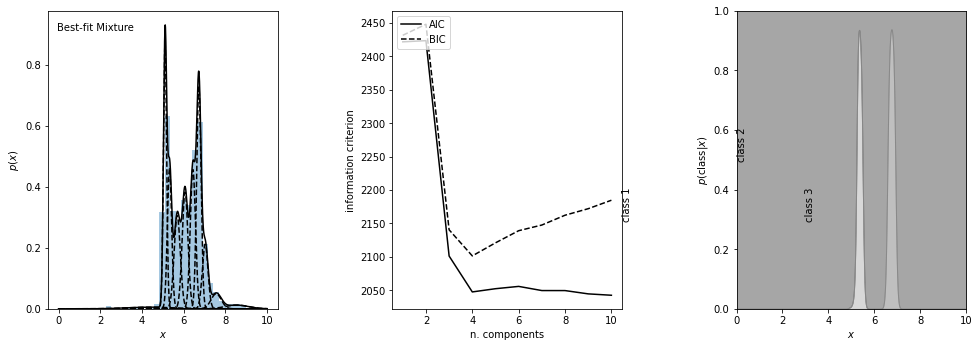

In [26]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

#-------------------------------------------------------
# Set up the dataset.
#  We'll create our dataset by drawing samples from Gaussians.

X = y_test_samples[7, :].reshape(-1, 1)
N = 10

data = X
max_components = N
gmm_args = dict(random_state=RANDOM_SEED, n_init=5)

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

models = []

for i in range(1, max_components + 1):
    models.append(GaussianMixture(i, **gmm_args).fit(data))

# compute the AIC and the BIC
AIC = [m.aic(data) for m in models]
BIC = [m.bic(data) for m in models]

M_best = models[np.argmin(AIC)]

print('Means: ')
print(M_best.means_)

print('Covariances: ')
print(M_best.covariances_)

print('Weights: ')
print(M_best.weights_)

# lowest_covariance = np.argmin(M_best.covariances_)
# model.means_[lowest_covariance], model.covariances_[lowest_covariance]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(15, 6))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(131)

x = np.linspace(0, 10, 1000)
logprob = M_best.score_samples(x.reshape(-1, 1))
responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(132)
ax.plot(range(1, N+1), AIC, '-k', label='AIC')
ax.plot(range(1, N+1), BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# plot 3: posterior probabilities for each component
ax = fig.add_subplot(133)

p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(0, 10)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show()